[*********************100%***********************]  1 of 1 completed

Missing values in each column:
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64
Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')
                                  Open         High          Low        Close  \
Datetime                                                                        
2024-08-20 09:15:00+05:30  4523.000000  4555.000000  4523.000000  4545.600098   
2024-08-20 09:20:00+05:30  4545.600098  4546.500000  4525.299805  4535.700195   
2024-08-20 09:25:00+05:30  4537.000000  4548.200195  4532.299805  4544.799805   
2024-08-20 09:30:00+05:30  4543.549805  4562.549805  4543.549805  4559.000000   
2024-08-20 09:35:00+05:30  4558.899902  4560.000000  4553.000000  4553.100098   

                             Adj Close  Volume  
Datetime                                        
2024-08-20 09:15:00+05:30  4545.600098       0  
2024-08-20 09:20:00+05:30  4535.700195   57779  
2024-08-20 09:25:00+05:

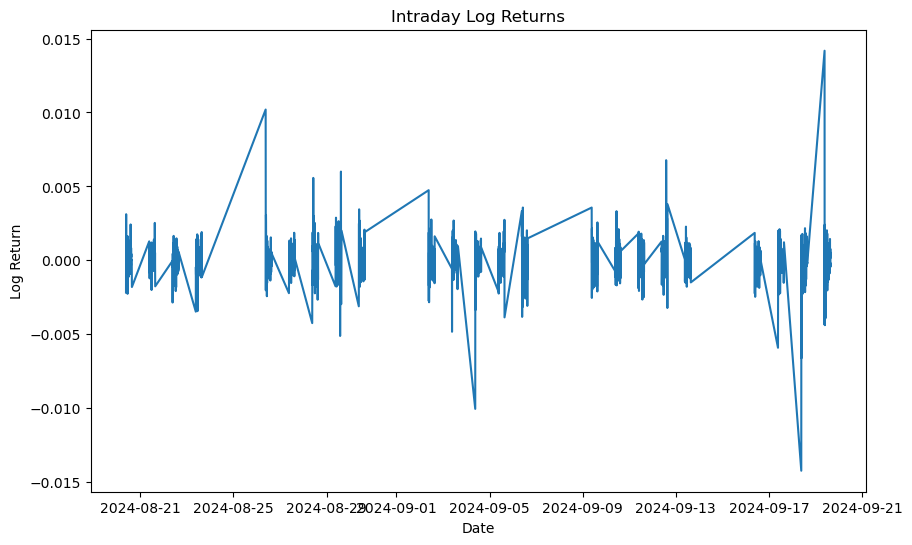

Mean of Log Returns: -3.2738111098872646e-05
Volatility of Log Returns: 0.0012369251173719735


In [6]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# We can fetch any stock data. Note: yahoo has a 15min delay. But no API token is needed for yfinance.
ticker = "TCS.NS"  # TCS on NSE
data = yf.download(ticker, interval="5m", period="1mo")     #Use time period 7d for 1minute interval.

# Counting total number of rows with null values. Dropna to drop rows with null values.
missing_values = data.isnull().sum()
print("Missing values in each column:")
print(missing_values)
data.dropna(inplace=True)


# I am saving as CSV for future validation if needed
data.to_csv('shares_prices.csv', index=True)

print(data.columns)
print(data.head(5))


# Checkinf for consistent time intervals
time_diffs = data.index.to_series().diff().dropna()
consistent_intervals = (time_diffs == pd.Timedelta(minutes=5)).all()
print(f"Consistent time intervals: {consistent_intervals}")

# Calculating the logarithmic returns
data['Log_Returns'] = np.log(data['Close'] / data['Close'].shift(1))
data.dropna(inplace=True)

# Plotting logarithmic returns to check for outliers
plt.figure(figsize=(10,6))
plt.plot(data['Log_Returns'])
plt.title('Intraday Log Returns')
plt.xlabel('Date')
plt.ylabel('Log Return')
plt.show()

#Mean & volatility Calculation
mean_return = data['Log_Returns'].mean()
volatility = data['Log_Returns'].std()

print(f"Mean of Log Returns: {mean_return}")
print(f"Volatility of Log Returns: {volatility}")



95% Value at Risk (VaR): -838.16
Expected Shortfall (CVaR): -1038.41


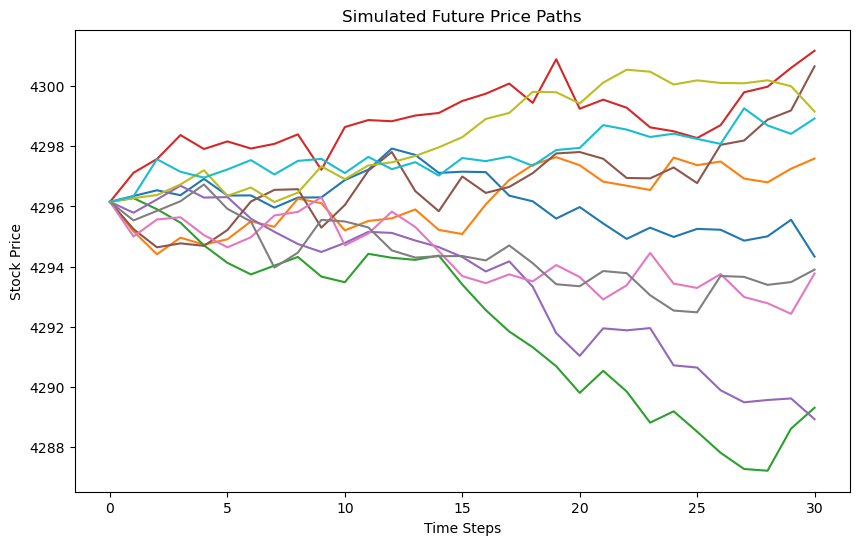

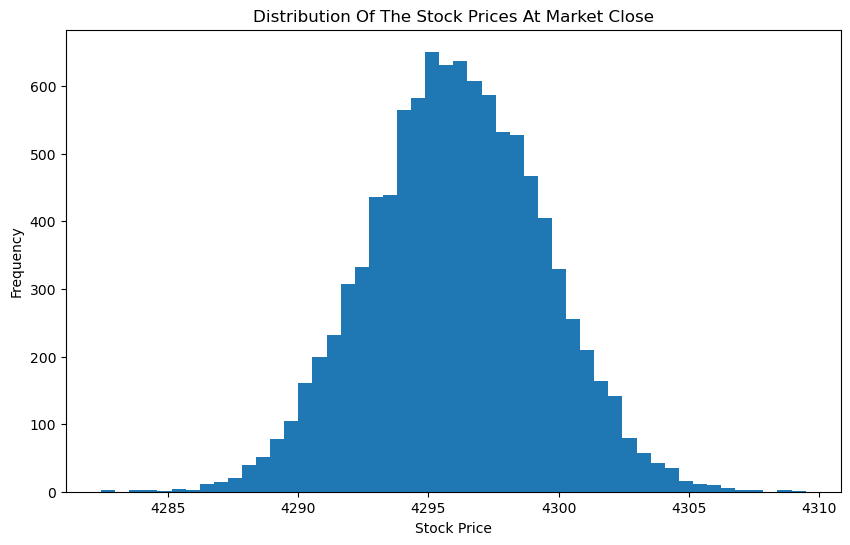

In [7]:

# Simulation parameters are below. We are considering 10000 simulations here.
mostRecent_close = data['Close'].iloc[-1]
delta_t = 5  # As we are using 5min time frame
T = 150  # Remaining time in minutes (1:00 PM to 3:30 PM)     
'''
Better to use this instead of hardcoding time
from datetime import datetime

curr_time = datetime.now()

# Format the time as HH:MM
time_string = curr_time.strftime("%H:%M")
round it to nearest 5 multiple and use it and if greater than 60 update hour.
'''
N = int(T / delta_t)  # Number of time steps
num_simulations = 10000
position_size = 150  # Number of shares held

# Initializing price paths
price_paths = np.zeros((N + 1, num_simulations))
price_paths[0] = mostRecent_close

delta_t_fraction = delta_t / 375  # Fraction of the trading day

# Simulation of price paths using GBM
for t in range(1, N + 1):
    epsilon = np.random.standard_normal(num_simulations)
    price_paths[t] = price_paths[t - 1] * np.exp(
        (mean_return - 0.5 * volatility**2) * delta_t_fraction + volatility * epsilon * np.sqrt(delta_t_fraction)
    )

# Calculating P&L
PnL = (price_paths[-1] - mostRecent_close) * position_size

# Risk metrics
confidence_level = 95
VaR = np.percentile(PnL, 100 - confidence_level)
expected_shortfall = PnL[PnL <= VaR].mean()

print(f"{confidence_level}% Value at Risk (VaR): {VaR:.2f}")
print(f"Expected Shortfall (CVaR): {expected_shortfall:.2f}")

# Plotting simulated price paths
plt.figure(figsize=(10,6))
plt.plot(price_paths[:, :10])
plt.title('Simulated Future Price Paths')
plt.xlabel('Time Steps')
plt.ylabel('Stock Price')
plt.show()

# Plotting distribution of final prices
plt.figure(figsize=(10,6))
plt.hist(price_paths[-1], bins=50)
plt.title('Distribution Of The Stock Prices At Market Close')
plt.xlabel('Stock Price')
plt.ylabel('Frequency')
plt.show()

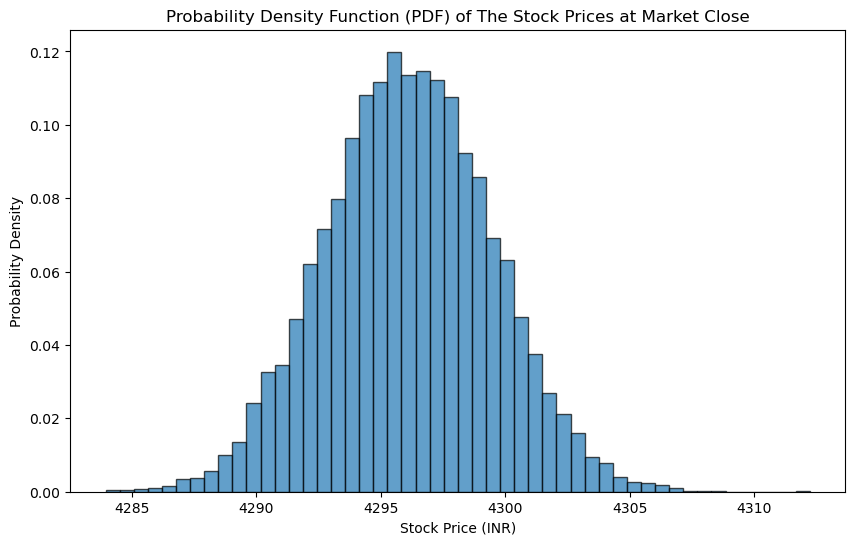

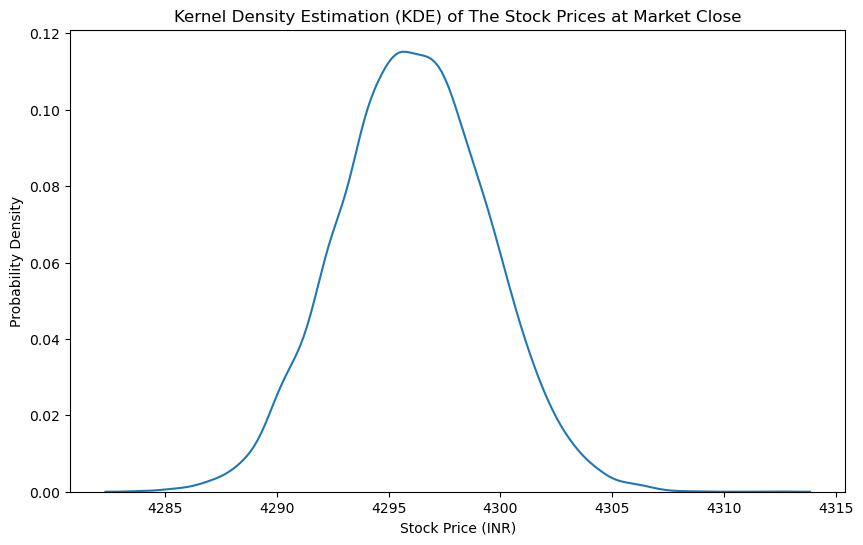

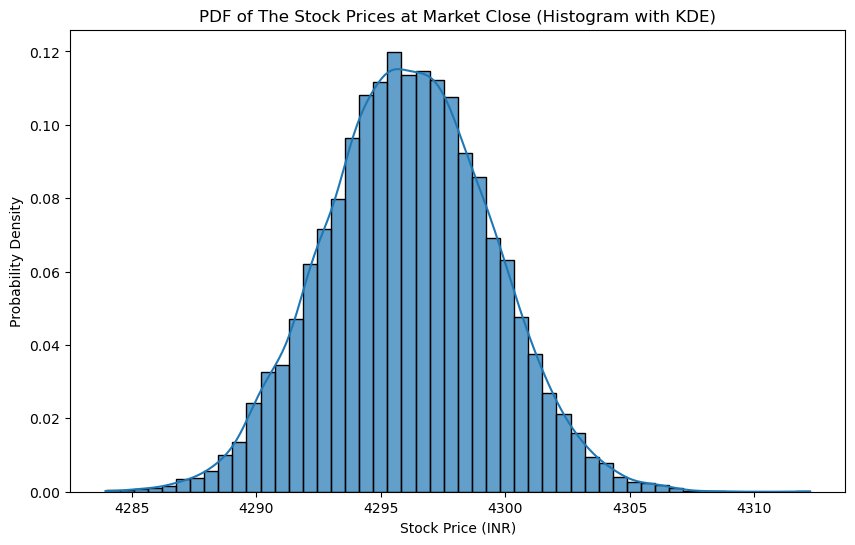

Estimated Probability that the stock will close below ₹4290: 3.21%


In [14]:
# Plotting normalized histogram (PDF)
plt.figure(figsize=(10,6))
plt.hist(price_paths[-1], bins=50, density=True, edgecolor='black', alpha=0.7)
plt.title('Probability Density Function (PDF) of The Stock Prices at Market Close')
plt.xlabel('Stock Price (INR)')
plt.ylabel('Probability Density')
plt.show()

# Plotting KDE
plt.figure(figsize=(10,6))
sns.kdeplot(price_paths[-1])
plt.title('Kernel Density Estimation (KDE) of The Stock Prices at Market Close')
plt.xlabel('Stock Price (INR)')
plt.ylabel('Probability Density')
plt.show()

# Overlay histogram and KDE
plt.figure(figsize=(10,6))
sns.histplot(price_paths[-1], bins=50, stat='density', kde=True, edgecolor='black', alpha=0.7)
plt.title('PDF of The Stock Prices at Market Close (Histogram with KDE)')
plt.xlabel('Stock Price (INR)')
plt.ylabel('Probability Density')
plt.show()

# Calculating probability of stock closing below a certain price
price_threshold = 4290

# Calculating the empirical cumulative distribution function (CDF)
sorted_prices = np.sort(price_paths[-1])
cdf = np.arange(1, len(sorted_prices)+1) / len(sorted_prices)

# Finding the probability
probability = 0  # If no prices are below the threshold, we set probability to 0
if np.any(sorted_prices <= price_threshold):
    probability = cdf[sorted_prices <= price_threshold].max()

print(f"Estimated Probability that the stock will close below ₹{price_threshold}: {probability:.2%}")


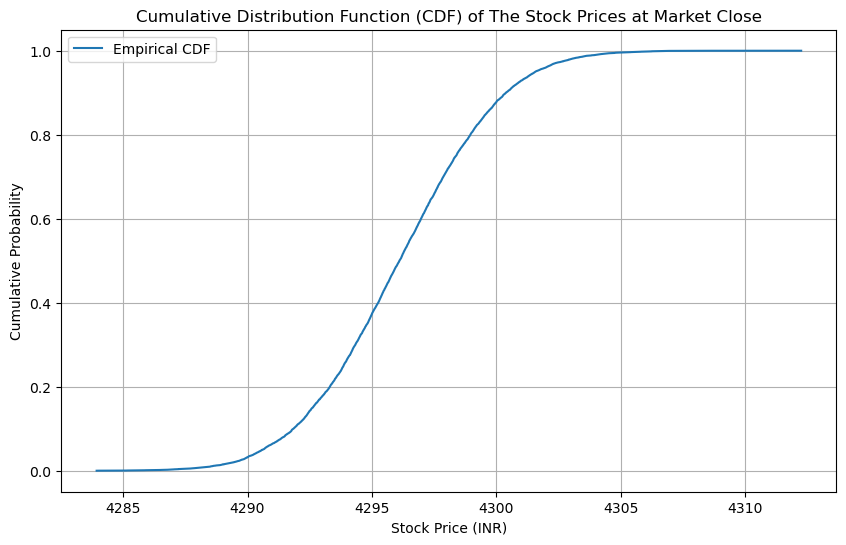

Estimated Probability that the stock will close at or below ₹4280: 0.00%
Estimated Probability that the stock will close above ₹4280: 100.00%


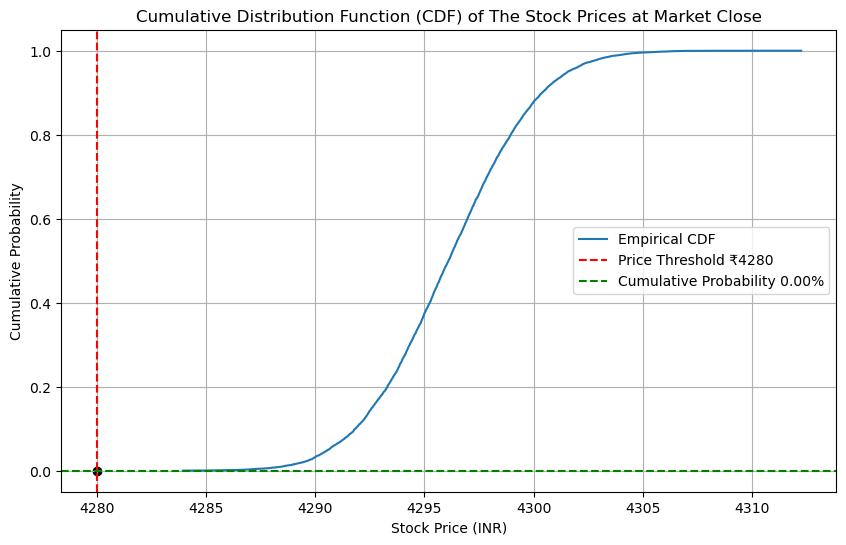

In [13]:
import numpy as np
import matplotlib.pyplot as plt

# Note: price_paths[-1] contains the final simulated stock prices

# Calculating the Empirical CDF
sorted_prices = np.sort(price_paths[-1])
num_simulations = len(sorted_prices)
cumulative_probs = np.arange(1, num_simulations + 1) / num_simulations


# Ploting the CDF
plt.figure(figsize=(10,6))
plt.plot(sorted_prices, cumulative_probs, label='Empirical CDF')
plt.title('Cumulative Distribution Function (CDF) of The Stock Prices at Market Close')
plt.xlabel('Stock Price (INR)')
plt.ylabel('Cumulative Probability')
plt.legend()
plt.grid(True)
plt.show()

# Calculate Probability of Stock Closing at or Below a Certain Price. Will use another procedure and push code again later to github.
price_threshold = 4280

# Finding the index where the sorted price exceeds the threshold
index = np.searchsorted(sorted_prices, price_threshold, side='right')

probability = 0.0
if index > 0:
    probability = cumulative_probs[index - 1]

print(f"Estimated Probability that the stock will close at or below ₹{price_threshold}: {probability:.2%}")

probability_above = 1 - probability
print(f"Estimated Probability that the stock will close above ₹{price_threshold}: {probability_above:.2%}")

# Plotting the CDF with Markers
plt.figure(figsize=(10,6))
plt.plot(sorted_prices, cumulative_probs, label='Empirical CDF')

# Marking the threshold price and cumulative probability
plt.axvline(price_threshold, color='red', linestyle='dashed', label=f'Price Threshold ₹{price_threshold}')
plt.axhline(probability, color='green', linestyle='dashed', label=f'Cumulative Probability {probability:.2%}')
plt.scatter([price_threshold], [probability], color='black')

plt.title('Cumulative Distribution Function (CDF) of The Stock Prices at Market Close')
plt.xlabel('Stock Price (INR)')
plt.ylabel('Cumulative Probability')
plt.legend()
plt.grid(True)
plt.show()
